In [43]:
import cv2
import glob
import numpy as np
from keras.layers import Conv2D, Dense, Flatten, Lambda, MaxPooling2D, Dropout, BatchNormalization
from keras.models import Model, Sequential
from moviepy.editor import VideoFileClip
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import pickle
import cars as c
import pipeline as p
from scipy.ndimage.measurements import label
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.callbacks import ModelCheckpoint


p.HEATMAP_THRESHOLD = 10
PROBABILITY_THRESHOLD = 0.9999
c.FRAME_COUNT_THRESHOLD = 20



# Train FCNN Classifier !!!

In [30]:
def timeStamp():
    import datetime
    now = datetime.datetime.now()
    y = now.year
    d = now.day
    mo = now.month
    h = now.hour
    m = now.minute
    s = now.second

    return '{}_{}_{}_{}_{}_{}'.format(y, mo, d, h, m, s)

def createSamples(x, y):
    """
    Returns a list of tuples (x, y)
    :param x: 
    :param y: 
    :return: 
    """
    assert len(x) == len(y)

    return [(x[i], y[i]) for i in range(len(x))]

def LoadData(imagePath):
    images = glob.glob(imagePath)
    data = []

    for image in images:
        data.append(image)
    return data

def prepareData():
    dataFile = 'data.p'
    if not os.path.isfile(dataFile):
        carTrainDataPath = "./data/vehicles/*/*.png"
        carTestDataPath = "./data/vehicles/*/test/*.png"
        notCarPath = "./data/non-vehicles/*/*.png"
        carsTrain = LoadData(carTrainDataPath)
        carsTest = LoadData(carTestDataPath)
        notCars = LoadData(notCarPath)
        rand_state = np.random.randint(0, 100)
        notcarTrain, notcarTest = train_test_split(notCars, train_size = 0.78, random_state=rand_state)

        xTest = carsTest + notcarTest
        print("Check test: {}".format(len(xTest)))

        yTest = np.hstack((np.ones(len(carsTest)), np.zeros(len(notcarTest))))

        xTrain = carsTrain + notcarTrain
        yTrain = np.hstack((np.ones(len(carsTrain)), np.zeros(len(notcarTrain))))

        # Further split train data to train and validation
        xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size=0.2, random_state=rand_state)
        data = {'xTrain': xTrain, 'xValidation': xVal, 'xTest': xTest,
                'yTrain': yTrain, 'yValidation': yVal, 'yTest': yTest}

        pickle.dump(data, open(dataFile, 'wb'))

        return xTrain, xVal, xTest, yTrain, yVal, yTest

    else:
        with open(dataFile, mode='rb') as f:
            data = pickle.load(f)

            xTrain = data['xTrain']
            xValidation = data['xValidation']
            xTest = data['xTest']
            yTrain = data['yTrain']
            yValidation = data['yValidation']
            yTest = data['yTest']

            return xTrain, xValidation, xTest, yTrain, yValidation, yTest


# Fully convolutional neural network model
def getFCNNModel(inputShape=(64, 64, 3)):
    """
    So-called 'Fully-convolutional Neural Network' (FCNN). Single filter in the top layer
    used for binary classification of 'vehicle/non-vehicle'
    :param inputShape: 
    :return: Keras model
    """
    model = Sequential()
    # Center and normalize our data
    model.add(Lambda(lambda x: (x / 127.5) - 1.0, input_shape=inputShape, output_shape=inputShape))
#     model.add(BatchNormalization())
    # Block 0
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', name='cv0', padding="same"))
    model.add(Dropout(0.5))

    # Block 1
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', name='cv1', padding="same"))
    model.add(Dropout(0.5))

    # block 2
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name='cv2', padding="same"))
    model.add(MaxPooling2D(pool_size=(8, 8)))
    model.add(Dropout(0.5))

    # binary 'classifier'
    model.add(Conv2D(filters=1, kernel_size=(8, 8), name='fcn', activation="sigmoid"))
#     model.add(Flatten())
#     model.add(Dense(1))

    return model


def generator(samples, batchSize=32, useFlips=False, resize=False):
    """
    Generator to supply batches of sample images and labels
    :param samples: list of sample images file names
    :param batchSize: 
    :param useFlips: adds horizontal flips if True (effectively inflates training set by a factor of 2)
    :param resize: Halves images widths and heights if True
    :return: batch of images and labels
    """
    samplesCount = len(samples)
    data_augmentation_multiplier = 1
    if useFlips:
        data_augmentation_multiplier *= 2
    print(data_augmentation_multiplier)
    while True:  # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, samplesCount, int(batchSize/data_augmentation_multiplier)):
            batchSamples = samples[offset:offset + batchSize]

            xTrain = []
            yTrain = []
            for batchSample in batchSamples:
                y = float(batchSample[1])

                fileName = batchSample[0]

                image = cv2.imread(fileName)

                xTrain.append(image)
                yTrain.append(y)

                if useFlips:
                    flipImg = cv2.flip(image, 1)
                    xTrain.append(flipImg)
                    yTrain.append(y)

            xTrain = np.array(xTrain)
            yTrain = np.expand_dims(yTrain, axis=1)

            yield shuffle(xTrain, yTrain)  # Since we added flips, better shuffle again

In [28]:

xTrain, xVal, xTest, yTrain, yVal, yTest = prepareData()
trainSamples = createSamples(xTrain, yTrain)
validationSamples = createSamples(xVal, yVal)


sourceModel = getFCNNModel()
print(sourceModel.summary())

# Adding fully-connected layer to train the 'classifier'
x = sourceModel.output
x = Flatten()(x)
fcnnModel = Model(inputs=sourceModel.input, outputs=x)
print(fcnnModel.summary())

fcnnModel.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

trainGen = generator(samples=trainSamples, useFlips=True)
validGen = generator(samples=validationSamples, useFlips=True)

batchSize = 32
epochCount = 10
stepsPerEpoch = len(trainSamples) / batchSize
timeStamp = timeStamp()
weightsFile = '{}_{}.h5'.format("FCNNModel", timeStamp)

checkpointer = ModelCheckpoint(filepath=weightsFile,
                               monitor='val_acc', verbose=1, save_best_only=True)

validationSteps = len(validationSamples) / batchSize

_ = fcnnModel.fit_generator(trainGen,
                            steps_per_epoch=stepsPerEpoch,
                            validation_data=validGen,
                            validation_steps=validationSteps,
                            epochs=epochCount, callbacks=[checkpointer])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_11 (Lambda)           (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
cv0 (Conv2D)                 (None, 64, 64, 16)        448       
_________________________________________________________________
dropout_31 (Dropout)         (None, 64, 64, 16)        0         
_________________________________________________________________
cv1 (Conv2D)                 (None, 64, 64, 32)        4640      
_________________________________________________________________
dropout_32 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
cv2 (Conv2D)                 (None, 64, 64, 64)        18496     
__________

In [ ]:
print('Training complete. Weights for best validation accuracy have been saved to {}.'
              .format(weightsFile))
# Evaluating accuracy on test set
print('Evaluating accuracy on test set.')
testSamples = createSamples(xTest, yTest)
testGen = generator(samples=testSamples, useFlips=False)
testSteps = len(testSamples) / batchSize
accuracy = fcnnModel.evaluate_generator(generator=testGen, steps=testSteps)

print('test accuracy: ', accuracy)

# Model Trained !!!!

In [40]:
class VehicleDetector:
    def __init__(self, imgInputShape=(720, 1280, 3), crop=(0.50, 0.90),
                 pointSize=64, confidenceThrd=PROBABILITY_THRESHOLD, veHiDepth=30,
                 groupThrd=10, groupDiff=.1):
        self.crop = crop
        self.confidenceThrd = confidenceThrd
        ipH = int(math.ceil((imgInputShape[0] * (crop[1] - crop[0]))))
        self.fcnnModel = getFCNNModel(inputShape=(ipH, imgInputShape[1], imgInputShape[2]))
        print(self.fcnnModel.summary())

        self.fcnnModel.load_weights('{}.h5'.format("FCNNModel"))

        # Custom kernel to consolidate diagonally-touching areas
        self.diagKernel = [[1, 1, 1],
                           [1, 1, 1],
                           [1, 1, 1]]

        pass

    def getRoi(self, img):
        image_length = img.shape[0] # 720
        start = int(image_length * self.crop[0])
        self.start_roi = start
        end = int(image_length * self.crop[1])
        roi = img[start:end, :]
        return roi
    

    def getRegions(self, roi):
        # Make roi of image as 4-D as input to predict expects 4-D
        roiW, roiH = roi.shape[1], roi.shape[0]
#         roi = np.expand_dims(roi, axis=0)
        roi = roi.reshape(1, roi.shape[0],roi.shape[1],roi.shape[2])

        detectionMap = self.fcnnModel.predict(roi)

        predictionMapH, predictionMapW = detectionMap.shape[1], detectionMap.shape[2]
        
        # ratio is used to map the detected vehicle points back to roi space.
        ratioH, ratioW = roiH / predictionMapH, roiW / predictionMapW

#         print(ratioH, ratioW)
        detectionMap = detectionMap.reshape(detectionMap.shape[1], detectionMap.shape[2])
        
        # Thresholding by the confidence. The predictions are actually VERY polarized,
        # sticking to mostly Zero for non-vehicle points and mostly Ones for vehicles.
        # That said, midpoint of 0.5 for confidence threshold seems to be a reliable choice.
        detectionMap = detectionMap > self.confidenceThrd

        hotRegions = []
    
        nz = detectionMap.nonzero()
        nzY = np.array(nz[0])
        nzX = np.array(nz[1])

        for x, y in zip(nzX, nzY):
            topLeftX = int(x * ratioW)
            topLeftY = int(y * ratioH) 
            bottomRightX = topLeftX + 64
            bottomRightY = topLeftY + 64 

            topLeft = (topLeftX, self.start_roi + topLeftY)
            bottomRight = (bottomRightX, self.start_roi + bottomRightY)

            hotRegions.append((topLeft, bottomRight))

        return hotRegions    


In [41]:
def colorHeatMap(heatMapMono, cmap=cv2.COLORMAP_HOT):
    """
    Makes an RGB version of the 1-channel heatMap
    :param heatMapMono: 
    :param cmap: The color map of choice
    :return: RGB heatMap
    """
    heatMapInt = cv2.equalizeHist(heatMapMono.astype(np.uint8))
    heatColor = cv2.applyColorMap(heatMapInt, cmap)
    heatColor = cv2.cvtColor(heatColor, code=cv2.COLOR_BGR2RGB)

    return heatColor

def process_image(img, debug=False):
    global vd
    global cars

    # Cropping to the region of interest
    
    roi = vd.getRoi(img)
    possible_cars = vd.getRegions(roi)
    print("possible_cars:", len(possible_cars))
    final_cars, heatmap = p.harden_detections_with_heat_map(img, possible_cars, 50)
    heatmap = colorHeatMap(heatmap)
    print("final_cars:", len(final_cars))

    if cars:
        cars_to_draw = cars.updateNewCars(final_cars)
#         print("cars_to_draw: {}".format(cars_to_draw))
        final_img = p.draw_boxes(np.copy(img), cars_to_draw)
    else:
        final_img = p.draw_boxes(np.copy(img), final_cars)

    if debug:
        pre_filter_img = p.draw_boxes(img, possible_cars)
        return final_img, pre_filter_img, heatmap
    else:
        smallHeatmap = cv2.resize(src=heatmap, dsize=(0, 0), fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)
        origin=(20, 20)
        pipHeight = smallHeatmap.shape[0]
        pipWidth = smallHeatmap.shape[1]
        final_img[origin[1]:origin[1] + pipHeight, origin[0]:origin[0] + pipWidth] = smallHeatmap

        return final_img


In [45]:
cars = c.Cars()
vd = VehicleDetector()
# clip = VideoFileClip("./project_video.mp4")
clip1 = VideoFileClip("./project_video.mp4")
clip = clip1.subclip(14, 18)
output_video = "./project_video_FCNN_marked.mp4"
output_clip = clip.fl_image(process_image)
output_clip.write_videofile(output_video)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_16 (Lambda)           (None, 288, 1280, 3)      0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 288, 1280, 3)      12        
_________________________________________________________________
cv0 (Conv2D)                 (None, 288, 1280, 16)     448       
_________________________________________________________________
dropout_46 (Dropout)         (None, 288, 1280, 16)     0         
_________________________________________________________________
cv1 (Conv2D)                 (None, 288, 1280, 32)     4640      
_________________________________________________________________
dropout_47 (Dropout)         (None, 288, 1280, 32)     0         
_________________________________________________________________
cv2 (Conv2D)                 (None, 288, 1280, 64)     18496     
__________

100%|██████████| 89/89 [00:00<00:00, 1353.22it/s]

[MoviePy] Done.
[MoviePy] Writing video ./project_video_FCNN_marked.mp4



  1%|          | 1/101 [00:00<00:59,  1.68it/s]

possible_cars: 5
Labels: 0
final_cars: 0
Returning 0 cars to draw


  2%|▏         | 2/101 [00:01<00:58,  1.69it/s]

possible_cars: 9
Labels: 0
final_cars: 0
Returning 0 cars to draw


  3%|▎         | 3/101 [00:01<00:57,  1.72it/s]

possible_cars: 3
Labels: 0
final_cars: 0
Returning 0 cars to draw


  4%|▍         | 4/101 [00:02<00:58,  1.66it/s]

possible_cars: 3
Labels: 0
final_cars: 0
Returning 0 cars to draw


  5%|▍         | 5/101 [00:02<00:57,  1.68it/s]

possible_cars: 6
Labels: 0
final_cars: 0
Returning 0 cars to draw


  6%|▌         | 6/101 [00:03<00:55,  1.72it/s]

possible_cars: 22
Labels: 1
final_cars: 1
Adding 1 cars to empty tracked list
Returning 1 cars to draw


  7%|▋         | 7/101 [00:04<00:52,  1.78it/s]

possible_cars: 20
Labels: 1
final_cars: 1
Found match
Update match
Returning 1 cars to draw


  8%|▊         | 8/101 [00:04<00:51,  1.82it/s]

possible_cars: 7
Labels: 0
final_cars: 0
Add previously tracked car
Returning 1 cars to draw


  9%|▉         | 9/101 [00:05<00:50,  1.83it/s]

possible_cars: 13
Labels: 1
final_cars: 1
Found match
Update match
Returning 1 cars to draw


 10%|▉         | 10/101 [00:05<00:49,  1.85it/s]

possible_cars: 19
Labels: 1
final_cars: 1
Found match
Update match
Returning 1 cars to draw


 11%|█         | 11/101 [00:06<00:48,  1.86it/s]

possible_cars: 21
Labels: 1
final_cars: 1
Found match
Update match
Returning 1 cars to draw


 12%|█▏        | 12/101 [00:06<00:47,  1.87it/s]

possible_cars: 11
Labels: 1
final_cars: 1
Found match
Update match
Returning 1 cars to draw


 13%|█▎        | 13/101 [00:07<00:46,  1.87it/s]

possible_cars: 12
Labels: 1
final_cars: 1
Found match
Update match
Returning 1 cars to draw


 14%|█▍        | 14/101 [00:07<00:47,  1.84it/s]

possible_cars: 4
Labels: 0
final_cars: 0
Add previously tracked car
Returning 1 cars to draw


 15%|█▍        | 15/101 [00:08<00:46,  1.85it/s]

possible_cars: 3
Labels: 0
final_cars: 0
Add previously tracked car
Returning 1 cars to draw


 16%|█▌        | 16/101 [00:08<00:47,  1.81it/s]

possible_cars: 4
Labels: 0
final_cars: 0
Add previously tracked car
Returning 1 cars to draw


 17%|█▋        | 17/101 [00:09<00:46,  1.79it/s]

possible_cars: 5
Labels: 0
final_cars: 0
Add previously tracked car
Returning 1 cars to draw


 18%|█▊        | 18/101 [00:10<00:46,  1.80it/s]

possible_cars: 7
Labels: 0
final_cars: 0
Add previously tracked car
Returning 1 cars to draw


 19%|█▉        | 19/101 [00:10<00:45,  1.79it/s]

possible_cars: 6
Labels: 0
final_cars: 0
Add previously tracked car
Returning 1 cars to draw


 20%|█▉        | 20/101 [00:11<00:45,  1.76it/s]

possible_cars: 8
Labels: 0
final_cars: 0
Add previously tracked car
Returning 1 cars to draw


 21%|██        | 21/101 [00:11<00:45,  1.75it/s]

possible_cars: 8
Labels: 0
final_cars: 0
Add previously tracked car
Returning 1 cars to draw


 22%|██▏       | 22/101 [00:12<00:45,  1.73it/s]

possible_cars: 5
Labels: 0
final_cars: 0
Retiring car
Returning 0 cars to draw


 23%|██▎       | 23/101 [00:12<00:45,  1.73it/s]

possible_cars: 6
Labels: 0
final_cars: 0
Returning 0 cars to draw


 24%|██▍       | 24/101 [00:13<00:44,  1.72it/s]

possible_cars: 8
Labels: 0
final_cars: 0
Returning 0 cars to draw


 25%|██▍       | 25/101 [00:14<00:43,  1.74it/s]

possible_cars: 6
Labels: 0
final_cars: 0
Returning 0 cars to draw


 26%|██▌       | 26/101 [00:14<00:42,  1.75it/s]

possible_cars: 34
Labels: 1
final_cars: 1
Adding 1 cars to empty tracked list
Returning 1 cars to draw


 27%|██▋       | 27/101 [00:15<00:41,  1.78it/s]

possible_cars: 27
Labels: 1
final_cars: 1
Found match
Update match
Returning 1 cars to draw


 28%|██▊       | 28/101 [00:15<00:41,  1.77it/s]

possible_cars: 35
Labels: 1
final_cars: 1
Found match
Update match
Returning 1 cars to draw


 29%|██▊       | 29/101 [00:16<00:41,  1.74it/s]

possible_cars: 8
Labels: 0
final_cars: 0
Add previously tracked car
Returning 1 cars to draw


 30%|██▉       | 30/101 [00:16<00:41,  1.73it/s]

possible_cars: 5
Labels: 0
final_cars: 0
Add previously tracked car
Returning 1 cars to draw


 31%|███       | 31/101 [00:17<00:40,  1.73it/s]

possible_cars: 7
Labels: 0
final_cars: 0
Add previously tracked car
Returning 1 cars to draw


 32%|███▏      | 32/101 [00:18<00:40,  1.71it/s]

possible_cars: 4
Labels: 0
final_cars: 0
Add previously tracked car
Returning 1 cars to draw


 33%|███▎      | 33/101 [00:18<00:40,  1.70it/s]

possible_cars: 8
Labels: 0
final_cars: 0
Retiring car
Returning 0 cars to draw


 34%|███▎      | 34/101 [00:19<00:39,  1.68it/s]

possible_cars: 8
Labels: 0
final_cars: 0
Returning 0 cars to draw


 35%|███▍      | 35/101 [00:19<00:39,  1.68it/s]

possible_cars: 4
Labels: 0
final_cars: 0
Returning 0 cars to draw


 36%|███▌      | 36/101 [00:20<00:39,  1.66it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 37%|███▋      | 37/101 [00:21<00:37,  1.69it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 38%|███▊      | 38/101 [00:21<00:37,  1.69it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 39%|███▊      | 39/101 [00:22<00:36,  1.69it/s]

possible_cars: 3
Labels: 0
final_cars: 0
Returning 0 cars to draw


 40%|███▉      | 40/101 [00:22<00:36,  1.68it/s]

possible_cars: 2
Labels: 0
final_cars: 0
Returning 0 cars to draw


 41%|████      | 41/101 [00:23<00:36,  1.64it/s]

possible_cars: 25
Labels: 1
final_cars: 1
Adding 1 cars to empty tracked list
Returning 1 cars to draw


 42%|████▏     | 42/101 [00:24<00:35,  1.65it/s]

possible_cars: 15
Labels: 1
final_cars: 1
Found match
Update match
Returning 1 cars to draw


 43%|████▎     | 43/101 [00:24<00:35,  1.62it/s]

possible_cars: 4
Labels: 0
final_cars: 0
Add previously tracked car
Returning 1 cars to draw


 44%|████▎     | 44/101 [00:25<00:35,  1.62it/s]

possible_cars: 9
Labels: 0
final_cars: 0
Add previously tracked car
Returning 1 cars to draw


 45%|████▍     | 45/101 [00:25<00:34,  1.62it/s]

possible_cars: 2
Labels: 0
final_cars: 0
Add previously tracked car
Returning 1 cars to draw


 46%|████▌     | 46/101 [00:26<00:33,  1.64it/s]

possible_cars: 5
Labels: 0
final_cars: 0
Retiring car
Returning 0 cars to draw


 47%|████▋     | 47/101 [00:27<00:32,  1.64it/s]

possible_cars: 7
Labels: 0
final_cars: 0
Returning 0 cars to draw


 48%|████▊     | 48/101 [00:27<00:33,  1.60it/s]

possible_cars: 3
Labels: 0
final_cars: 0
Returning 0 cars to draw


 49%|████▊     | 49/101 [00:28<00:33,  1.56it/s]

possible_cars: 10
Labels: 0
final_cars: 0
Returning 0 cars to draw


 50%|████▉     | 50/101 [00:29<00:32,  1.57it/s]

possible_cars: 9
Labels: 0
final_cars: 0
Returning 0 cars to draw


 50%|█████     | 51/101 [00:29<00:32,  1.55it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 51%|█████▏    | 52/101 [00:30<00:32,  1.53it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 52%|█████▏    | 53/101 [00:31<00:31,  1.54it/s]

possible_cars: 3
Labels: 0
final_cars: 0
Returning 0 cars to draw


 53%|█████▎    | 54/101 [00:31<00:29,  1.57it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 54%|█████▍    | 55/101 [00:32<00:28,  1.59it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 55%|█████▌    | 56/101 [00:32<00:28,  1.58it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 56%|█████▋    | 57/101 [00:33<00:28,  1.57it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 57%|█████▋    | 58/101 [00:34<00:26,  1.60it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 58%|█████▊    | 59/101 [00:34<00:26,  1.57it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 59%|█████▉    | 60/101 [00:35<00:26,  1.57it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 60%|██████    | 61/101 [00:36<00:25,  1.59it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 61%|██████▏   | 62/101 [00:36<00:24,  1.59it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 62%|██████▏   | 63/101 [00:37<00:23,  1.60it/s]

possible_cars: 2
Labels: 0
final_cars: 0
Returning 0 cars to draw


 63%|██████▎   | 64/101 [00:38<00:23,  1.59it/s]

possible_cars: 13
Labels: 1
final_cars: 1
Adding 1 cars to empty tracked list
Returning 1 cars to draw


 64%|██████▍   | 65/101 [00:38<00:22,  1.60it/s]

possible_cars: 9
Labels: 0
final_cars: 0
Add previously tracked car
Returning 1 cars to draw


 65%|██████▌   | 66/101 [00:39<00:21,  1.60it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Add previously tracked car
Returning 1 cars to draw


 66%|██████▋   | 67/101 [00:39<00:21,  1.59it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Retiring car
Returning 0 cars to draw


 67%|██████▋   | 68/101 [00:40<00:20,  1.61it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 68%|██████▊   | 69/101 [00:41<00:19,  1.64it/s]

possible_cars: 1
Labels: 0
final_cars: 0
Returning 0 cars to draw


 69%|██████▉   | 70/101 [00:41<00:19,  1.62it/s]

possible_cars: 17
Labels: 1
final_cars: 1
Adding 1 cars to empty tracked list
Returning 1 cars to draw


 70%|███████   | 71/101 [00:42<00:18,  1.63it/s]

possible_cars: 3
Labels: 0
final_cars: 0
Add previously tracked car
Returning 1 cars to draw


 71%|███████▏  | 72/101 [00:42<00:17,  1.63it/s]

possible_cars: 1
Labels: 0
final_cars: 0
Add previously tracked car
Returning 1 cars to draw


 72%|███████▏  | 73/101 [00:43<00:17,  1.60it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Retiring car
Returning 0 cars to draw


 73%|███████▎  | 74/101 [00:44<00:16,  1.61it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 74%|███████▍  | 75/101 [00:44<00:16,  1.61it/s]

possible_cars: 1
Labels: 0
final_cars: 0
Returning 0 cars to draw


 75%|███████▌  | 76/101 [00:45<00:15,  1.61it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 76%|███████▌  | 77/101 [00:46<00:14,  1.62it/s]

possible_cars: 3
Labels: 0
final_cars: 0
Returning 0 cars to draw


 77%|███████▋  | 78/101 [00:46<00:14,  1.62it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 78%|███████▊  | 79/101 [00:47<00:13,  1.63it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 79%|███████▉  | 80/101 [00:47<00:13,  1.61it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 80%|████████  | 81/101 [00:48<00:12,  1.60it/s]

possible_cars: 5
Labels: 0
final_cars: 0
Returning 0 cars to draw


 81%|████████  | 82/101 [00:49<00:11,  1.59it/s]

possible_cars: 11
Labels: 1
final_cars: 1
Adding 1 cars to empty tracked list
Returning 1 cars to draw


 82%|████████▏ | 83/101 [00:49<00:11,  1.60it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Add previously tracked car
Returning 1 cars to draw


 83%|████████▎ | 84/101 [00:50<00:10,  1.61it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Add previously tracked car
Returning 1 cars to draw


 84%|████████▍ | 85/101 [00:51<00:09,  1.61it/s]

possible_cars: 3
Labels: 0
final_cars: 0
Retiring car
Returning 0 cars to draw


 85%|████████▌ | 86/101 [00:51<00:09,  1.60it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 86%|████████▌ | 87/101 [00:52<00:08,  1.59it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 87%|████████▋ | 88/101 [00:52<00:08,  1.59it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 88%|████████▊ | 89/101 [00:53<00:07,  1.57it/s]

possible_cars: 4
Labels: 0
final_cars: 0
Returning 0 cars to draw


 89%|████████▉ | 90/101 [00:54<00:07,  1.56it/s]

possible_cars: 3
Labels: 0
final_cars: 0
Returning 0 cars to draw


 90%|█████████ | 91/101 [00:54<00:06,  1.55it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 91%|█████████ | 92/101 [00:55<00:05,  1.54it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 92%|█████████▏| 93/101 [00:56<00:05,  1.53it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 93%|█████████▎| 94/101 [00:56<00:04,  1.52it/s]

possible_cars: 1
Labels: 0
final_cars: 0
Returning 0 cars to draw


 94%|█████████▍| 95/101 [00:57<00:03,  1.51it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 95%|█████████▌| 96/101 [00:58<00:03,  1.51it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 96%|█████████▌| 97/101 [00:58<00:02,  1.49it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 97%|█████████▋| 98/101 [00:59<00:02,  1.49it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 98%|█████████▊| 99/101 [01:00<00:01,  1.48it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


 99%|█████████▉| 100/101 [01:01<00:00,  1.43it/s]

possible_cars: 0
Labels: 0
final_cars: 0
Returning 0 cars to draw


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_FCNN_marked.mp4 



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_15 (Lambda)           (None, 288, 1280, 3)      0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 288, 1280, 3)      12        
_________________________________________________________________
cv0 (Conv2D)                 (None, 288, 1280, 16)     448       
_________________________________________________________________
dropout_43 (Dropout)         (None, 288, 1280, 16)     0         
_________________________________________________________________
cv1 (Conv2D)                 (None, 288, 1280, 32)     4640      
_________________________________________________________________
dropout_44 (Dropout)         (None, 288, 1280, 32)     0         
_________________________________________________________________
cv2 (Conv2D)                 (None, 288, 1280, 64)     18496     
__________

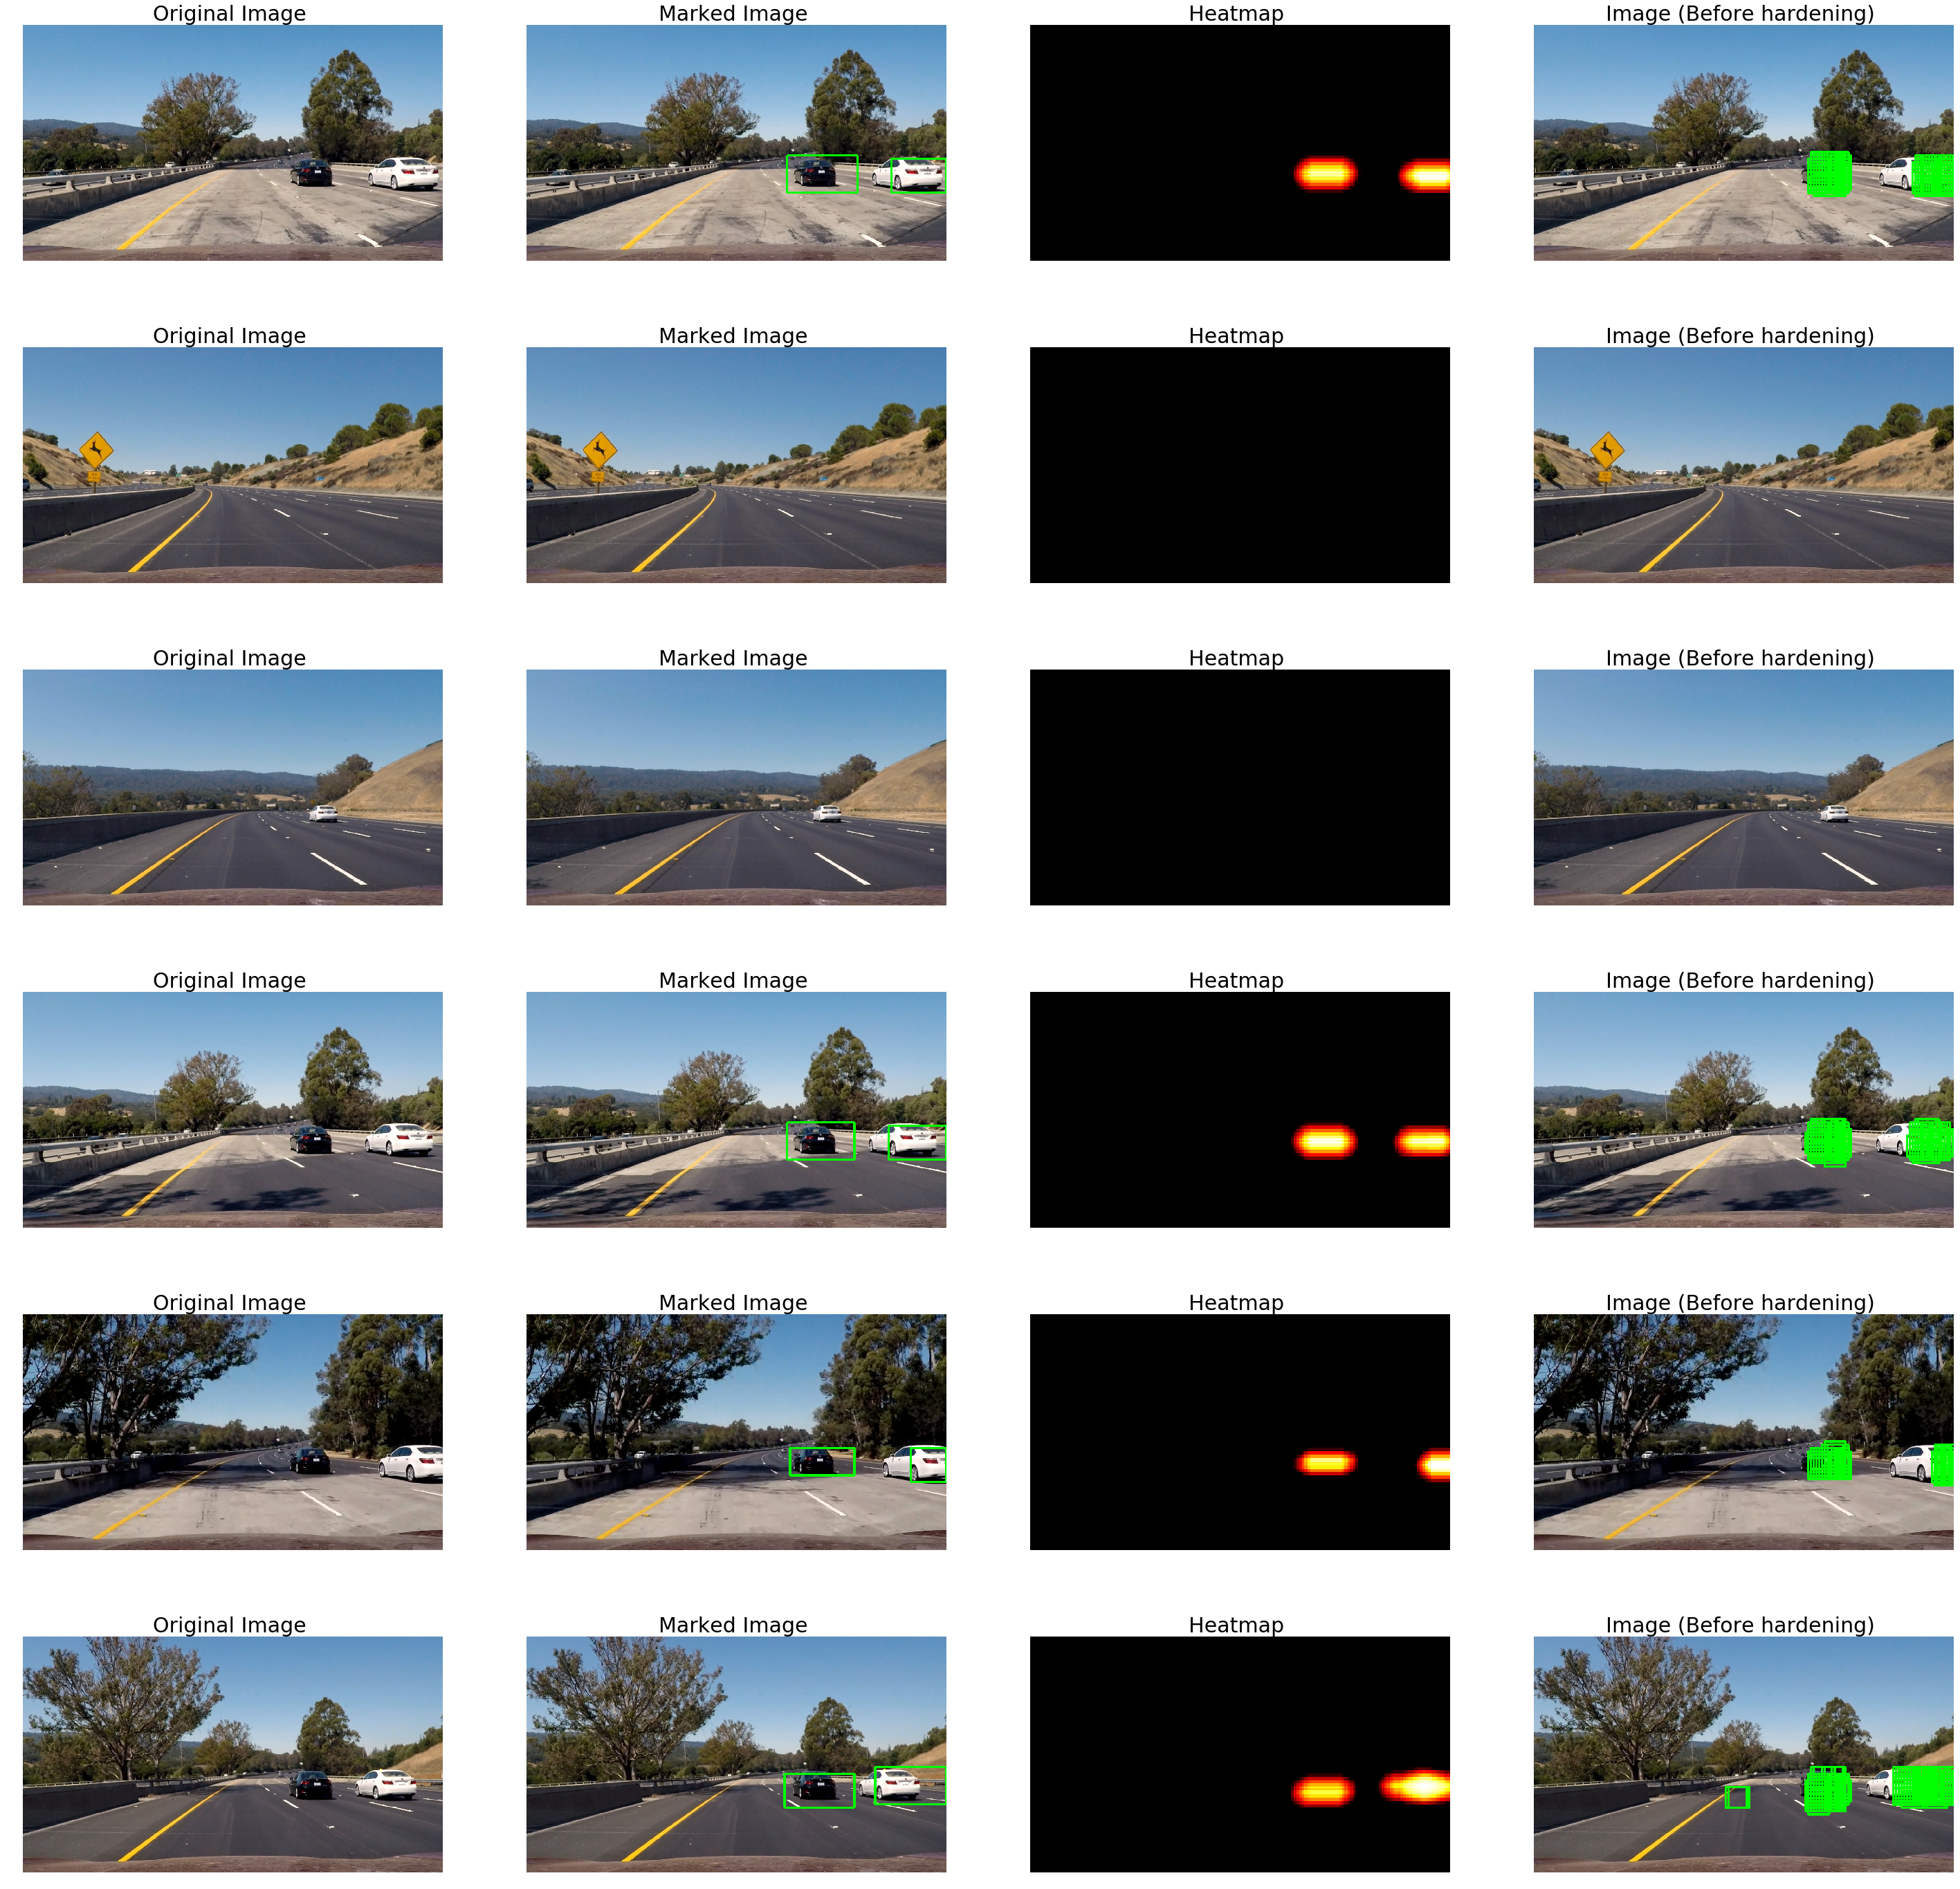

In [44]:
# Test images
vd = VehicleDetector()
cars = None

image_path = "./test_images/*.jpg"
images = glob.glob(image_path)

fig = plt.figure()
fig.set_size_inches(50,50)

total_image_count = len(images)
image_count = 1

num_plots = 4

for fname in images:
    print("Testing image {}".format(fname))

    img = mpimg.imread(fname)
    marked_img, pre_filter_img, heatmap = process_image(img, debug=True)

    ax = fig.add_subplot(total_image_count, num_plots, image_count)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Original Image ', fontsize=30)
    image_count += 1

    ax = fig.add_subplot(total_image_count, num_plots, image_count)
    ax.imshow(marked_img)
    ax.axis('off')
    ax.set_title('Marked Image ', fontsize=30)
    image_count += 1

    
    ax = fig.add_subplot(total_image_count, num_plots, image_count)
    ax.imshow(heatmap)
    ax.axis('off')
    ax.set_title('Heatmap ', fontsize=30)
    image_count += 1
        
    ax = fig.add_subplot(total_image_count, num_plots, image_count)
    ax.imshow(pre_filter_img)
    ax.axis('off')
    ax.set_title('Image (Before hardening) ', fontsize=30)
    image_count += 1
    
    cv2.imwrite('./output_images/Marked_' + os.path.split(fname)[-1], marked_img)
    cv2.imwrite('./output_images/pre_filter_img_' + os.path.split(fname)[-1], pre_filter_img)

plt.show()